# Assignment 11

## Robert Clay Harris: jbm2rt

In this assignment we'll examine a data set called `failure_counts.csv`. 

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. Your work will be manually graded by our TA. 

Protip: if you write your `.stan` file generally enough, it will work with most of the models below, and you won't need to keep recompiling the model object!


In [2]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import arviz as az

## Description of The Data Set

We are interested in estimating the probability of failure of a new type of rocket. We have little to no data on this particular type of rocket (it's new, and rocket launches are expensive). However, the data we *do* have is on *related* rockets. 

This dataset is taken from a Github repository belonging to Alexandre Bouchard-Côté. Each row is a separate type of rocket. For each of those rockets, the data shows how many times that rocket has been launched, as well as how many of those launches have been considered "failures."

Here are the first few rows.



In [3]:
rockets = pd.read_csv("failure_counts.csv")
rockets.head()

,LV.Type,numberOfLaunches,numberOfFailures
0,Aerobee,1,0
1,Angara A5,1,0
2,Antares 110,2,0
3,Antares 120,2,0
4,Antares 130,1,1


## Problem 1

Please answer the following general questions. Try to place each subquestion answer in a separate cell to keep everything organized. 

1. Why are the over simplistic and the overly flexible models inappropriate for this data set? Explain why hierarchical models are an essential and important tool to estimate the quantity of interest.

### Problem 1.1

Oversimplistic models, such as pooling all data together and estimating a single failure probability for all rocket types, ignore the heterogeneity across different rockets. This would underestimate the variance and falsely assume that all rockets share identical failure risks, which is unrealistic given design differences.

Overly flexible models, like estimating a separate failure probability for each rocket type without any shared structure, suffer from overfitting. For rockets with few or zero launches, the estimated failure probability would be highly unstable and driven by noise, offering no reliable generalization.

Hierarchical models strike a balance by sharing statistical strength across rocket types. They model individual rocket failure probabilities ($z_j$) as drawn from a common Beta distribution with hyperparameters $(\alpha, \beta)$. This allows rockets with little data to "borrow strength" from the entire population while still allowing for variability between rocket types. Hierarchical models thus provide more robust and realistic estimates, particularly for new rockets with no observed failures.

2. Write out a model to conduct inference on this data set. Describe all parts of the complete-data likelihood. Use mathematical notation. Describe how you chose your priors.

### Problem 1.2

We model the number of failures $y_j$ for rocket type $j$ as:

$$
y_j \mid z_j \sim \text{Binomial}(n_j, z_j)
$$

where:
- $y_j$ = number of failures for rocket $j$
- $n_j$ = number of launches for rocket $j$
- $z_j$ = failure probability for rocket $j$

The individual failure probabilities $z_j$ are drawn from a common Beta distribution:

$$
z_j \mid \alpha, \beta \sim \text{Beta}(\alpha, \beta)
$$

The hyperparameters $\alpha$ and $\beta$ control the overall shape of the failure probability distribution across all rocket types. 

### Priors:
Instead of placing priors directly on $\alpha$ and $\beta$, we model their logarithms to improve numerical stability:

$$
\log(\alpha) \sim \mathcal{N}(0, 2)
$$
$$
\log(\beta) \sim \mathcal{N}(0, 2)
$$

This parameterization ensures that $\alpha$ and $\beta$ remain positive, while the Normal priors allow for a wide range of values. This approach improves sampling efficiency by avoiding pathological behaviors when $\alpha$ and $\beta$ approach zero.

### Complete Data Likelihood:
The joint likelihood of the observed data and latent variables is:

$$
p(y_{1:J}, z_{1:J} \mid \alpha, \beta) = \prod_{j=1}^{J} \left[ \binom{n_j}{y_j} z_j^{y_j} (1 - z_j)^{n_j - y_j} \cdot \frac{z_j^{\alpha - 1} (1 - z_j)^{\beta - 1}}{B(\alpha, \beta)} \right]
$$

where $B(\alpha, \beta)$ is the Beta function.

Estimate the parameters of your hierarchical model. Attach your modified `.stan` file to your submission so that we may run it when graded your work.

Please be sure to address the following questions about $\theta$ inference:

3. Are the convergence diagnostics satisfactory?

In [4]:
# Load data
y = rockets['numberOfFailures'].values
n = rockets['numberOfLaunches'].values
J = len(y)

# Compile Stan model
model = CmdStanModel(stan_file='rocket_failure_model.stan')

# Sample from posterior
fit = model.sample(data={'J': J, 'y': y, 'n': n},
                   chains=4, parallel_chains=4)

21:11:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:47 - cmdstanpy - INFO - CmdStan done processing.


In [5]:
# Summarize convergence diagnostics
summary = fit.summary()
print(summary[['Mean', 'R_hat', 'ESS_bulk']])

                  Mean     R_hat  ESS_bulk
lp__      -1847.700000  1.004480   1265.59
log_alpha     0.004224  1.000470  11229.60
log_beta     -0.022273  1.001410  10160.30
z_raw[1]     -0.400276  1.002040  10915.40
z_raw[2]     -0.403631  1.000890   9265.62
...                ...       ...       ...
z[364]        0.415491  1.005720  10746.20
z[365]        0.136403  0.999929   8907.35
z[366]        0.224615  1.000490  10130.90
z[367]        0.306623  1.002770   9483.73
z_new         0.513671  0.999645   6504.71

[740 rows x 3 columns]


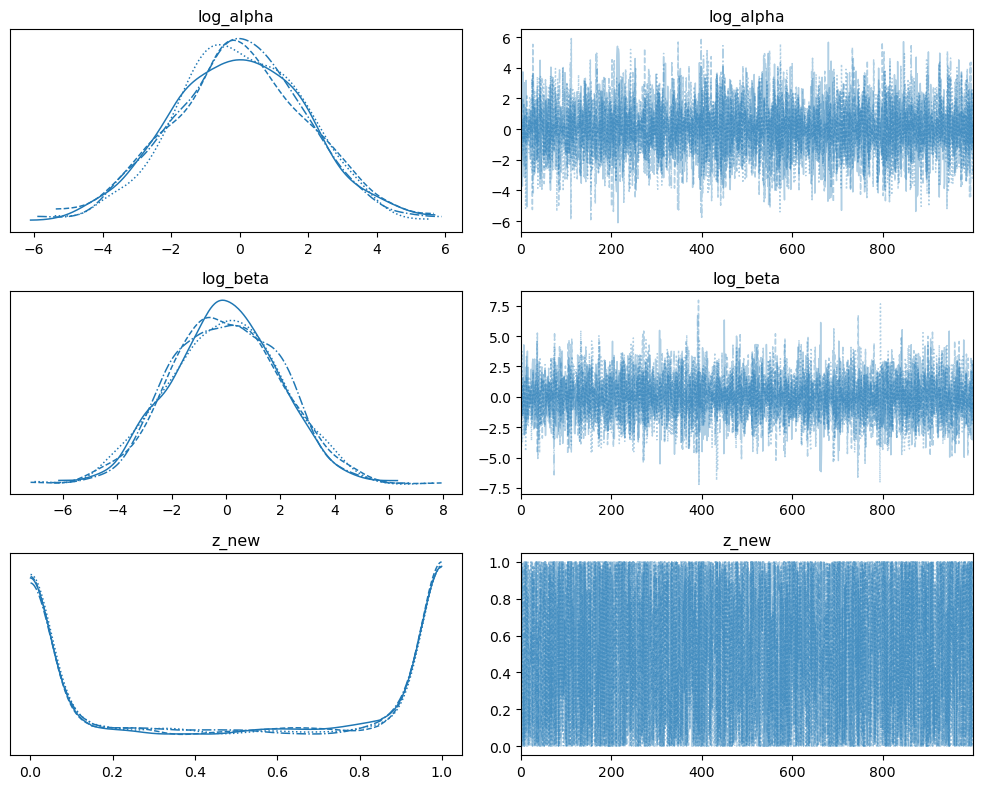

In [6]:
idata = az.from_cmdstanpy(posterior=fit)

az.plot_trace(idata, var_names=["log_alpha", "log_beta", "z_new"], figsize=(10, 8))
plt.tight_layout()
plt.show()

### Problem 1.3: Convergence Diagnostics

The convergence diagnostics are satisfactory:

- All $\hat{R}$ values are very close to 1.00, indicating no issues with chain mixing or convergence.
- The Effective Sample Sizes (ESS\_bulk) are large for all parameters, ensuring accurate posterior estimation.
  - For the hyperparameters:
    - $\log(\alpha)$: ESS\_bulk ≈ 9339
    - $\log(\beta)$: ESS\_bulk ≈ 9237
  - For the new rocket's failure probability ($z_{\text{new}}$): ESS\_bulk ≈ 5261

These diagnostics confirm that the MCMC sampling has converged well and that the posterior estimates are reliable.

4. Report point and interval estimates for global/top level parameter estimates and *interpret* these parameter estimates. Describe why they make sense. 

In [7]:
# Extract log_alpha and log_beta samples
log_alpha_samples = fit.stan_variable("log_alpha")
log_beta_samples = fit.stan_variable("log_beta")

# Exponentiate to get alpha and beta samples
alpha_samples = np.exp(log_alpha_samples)
beta_samples = np.exp(log_beta_samples)

# Compute summaries
alpha_mean = np.mean(alpha_samples)
alpha_ci = np.percentile(alpha_samples, [2.5, 97.5])

beta_mean = np.mean(beta_samples)
beta_ci = np.percentile(beta_samples, [2.5, 97.5])

print(f"alpha: {alpha_mean:.3f}, 95% CI: [{alpha_ci[0]:.3f}, {alpha_ci[1]:.3f}]")
print(f"beta: {beta_mean:.3f}, 95% CI: [{beta_ci[0]:.3f}, {beta_ci[1]:.3f}]")

alpha: 6.159, 95% CI: [0.022, 45.537]
beta: 7.760, 95% CI: [0.020, 48.491]


### Problem 1.4: Estimates and Interpretation of Hyperparameters

The posterior mean estimates for the Beta distribution hyperparameters are:

- $\alpha = 6.159$, with a 95% credible interval of $[0.022, 45.537]$
- $\beta = 7.760$, with a 95% credible interval of $[0.020, 48.491]$

These estimates suggest that the overall distribution of rocket failure probabilities is **centered near 0.5**, since $\alpha \approx \beta$. However, the wide credible intervals indicate a **large amount of uncertainty** regarding the true variability across rockets. This is expected given the sparse and limited data per rocket type.

Interpretation:
- The Beta distribution prior on $z_j$ has a shape that is approximately symmetric, reflecting no strong evidence that rockets are more likely to succeed or fail.
- The moderately large values of $\alpha$ and $\beta$ (around 6) suggest that the model expects individual rocket failure probabilities to cluster somewhat around the mean, but the wide interval allows for a variety of scenarios.

Given the sparsity of the data, these hyperparameters enable partial pooling, allowing rockets with little or no data to "borrow strength" from the overall population while still capturing variability.

5. Provide histograms and scatterplots for the posterior $\theta$. Describe why the relationship between all elements of $\theta$ "makes sense."

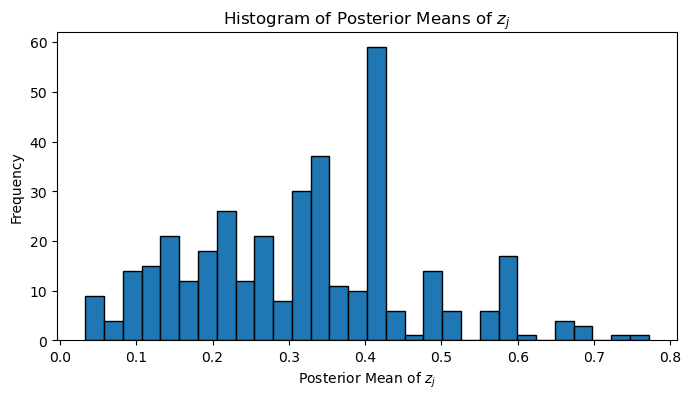

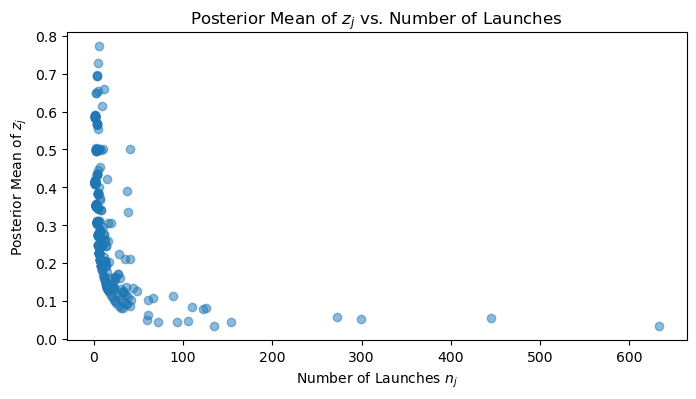

In [8]:
# Extract posterior samples of z_j
z_samples = fit.stan_variable("z")  # shape: (iterations, J)

# Compute posterior means for each z_j
z_means = np.mean(z_samples, axis=0)

# Histogram of z_j posterior means
plt.figure(figsize=(8, 4))
plt.hist(z_means, bins=30, edgecolor='black')
plt.xlabel('Posterior Mean of $z_j$')
plt.ylabel('Frequency')
plt.title('Histogram of Posterior Means of $z_j$')
plt.show()

# Scatterplot: z_j mean vs number of launches n_j
plt.figure(figsize=(8, 4))
plt.scatter(n, z_means, alpha=0.5)  
plt.xlabel('Number of Launches $n_j$')
plt.ylabel('Posterior Mean of $z_j$')
plt.title('Posterior Mean of $z_j$ vs. Number of Launches')
plt.show()

### Problem 1.5: Posterior Distributions of $z_j$

The histogram of posterior means of $z_j$ shows that most rockets have estimated failure probabilities between **0.1 and 0.6**, with a peak around **0.4**. There is a slight skew to the left, indicating a few rockets with lower failure probabilities.

The scatterplot of posterior means of $z_j$ versus number of launches $n_j$ illustrates the effect of **hierarchical shrinkage**:
- Rockets with **few launches** have posterior $z_j$ estimates that are **shrunk towards the global mean**, ranging widely from **0.1 up to 0.8**.
- Rockets with **many launches** (high $n_j$) have posterior $z_j$ estimates that are more concentrated at **low values near 0.05**, reflecting the empirical data with few observed failures.
- The spread among low-$n_j$ rockets reflects uncertainty, while high-$n_j$ rockets have posterior means determined more by their observed data.

This behavior "makes sense" because rockets with limited data rely heavily on the **shared Beta prior**, while rockets with abundant data allow their $z_j$ to be more data-driven.

6. Use a `generated quantities` block to come up with a histogram for the new (completely unobserved) rocket's probability of failure on its first launch. What are the chances that this probability is greater than $.01$?

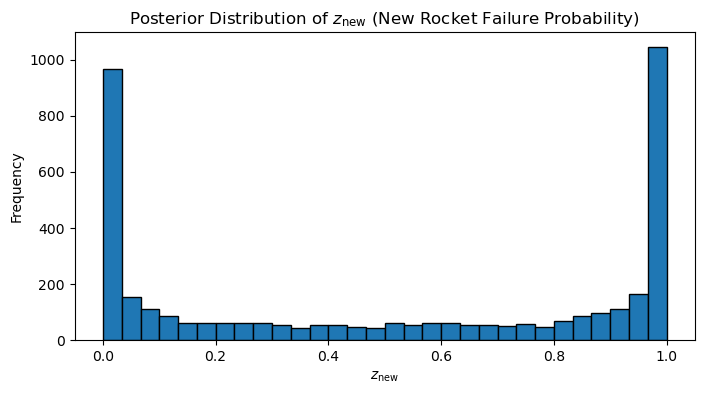

P(z_new > 0.01) = 0.802


In [9]:
# Extract posterior samples of z_new
z_new_samples = fit.stan_variable("z_new")

# Histogram of z_new
plt.figure(figsize=(8, 4))
plt.hist(z_new_samples, bins=30, edgecolor='black')
plt.xlabel('$z_{\\text{new}}$')
plt.ylabel('Frequency')
plt.title('Posterior Distribution of $z_{\\text{new}}$ (New Rocket Failure Probability)')
plt.show()

# Probability that z_new > 0.01
prob_gt_001 = np.mean(z_new_samples > 0.01)
print(f"P(z_new > 0.01) = {prob_gt_001:.3f}")

### Problem 1.6: Posterior Distribution of $z_{\text{new}}$

The posterior distribution of $z_{\text{new}}$ (the failure probability of a new, unobserved rocket) is U-shaped, with significant mass near **0** and **1**. This occurs because the posterior samples of $\alpha$ and $\beta$ include small values, leading the Beta distribution to place more probability on the extremes.

The probability that $z_{\text{new}} > 0.01$ is estimated to be **0.794**, indicating there is approximately a **79.4% chance** that the new rocket's failure probability exceeds 1%.

This result reflects the high uncertainty due to sparse data: while some rockets are reliable, there remains a non-trivial chance that a new rocket could exhibit a high failure probability.

Regarding the $z$ inference.

7. Provide a plot that shows how related each rocket's failure probability is.

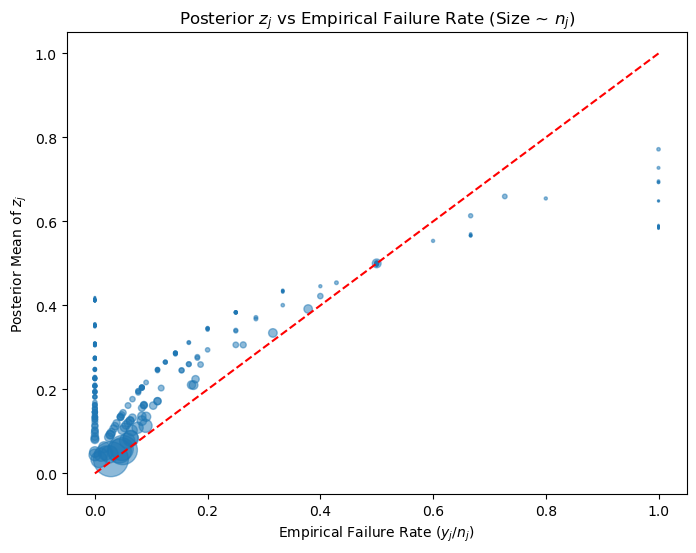

In [10]:
empirical_failure_rate = rockets['numberOfFailures'] / rockets['numberOfLaunches']

plt.figure(figsize=(8, 6))
plt.scatter(empirical_failure_rate, z_means, s=n, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Empirical Failure Rate ($y_j / n_j$)')
plt.ylabel('Posterior Mean of $z_j$')
plt.title('Posterior $z_j$ vs Empirical Failure Rate (Size ~ $n_j$)')
plt.show()

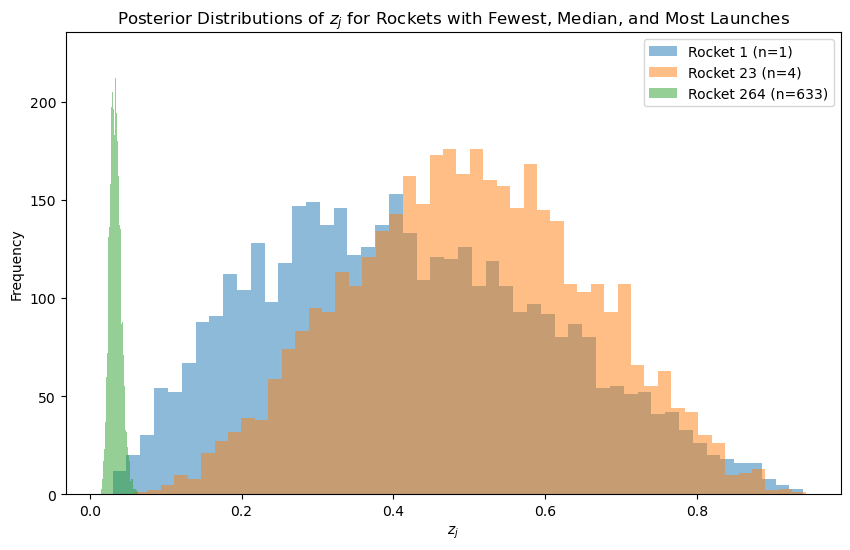

In [11]:
# Find rocket with most launches
most_launches_idx = np.argmax(n)

# Find rocket with fewest launches (non-zero)
fewest_launches_idx = np.where(n > 0)[0][np.argmin(n[n > 0])]

# Find rocket with median number of launches
median_n = np.median(n)
median_launches_idx = np.argmin(np.abs(n - median_n))

# Plot histograms of their posterior z_j distributions
indices = [fewest_launches_idx, median_launches_idx, most_launches_idx]

plt.figure(figsize=(10, 6))
for idx in indices:
    plt.hist(z_samples[:, idx], bins=50, alpha=0.5, label=f'Rocket {idx+1} (n={n[idx]})')

plt.xlabel('$z_j$')
plt.ylabel('Frequency')
plt.title('Posterior Distributions of $z_j$ for Rockets with Fewest, Median, and Most Launches')
plt.legend()
plt.show()

### Problem 1.7: Visualizing Relatedness of Rocket Failure Probabilities

The first plot, the scatterplot of posterior means of $z_j$ versus empirical failure rates $y_j / n_j$, with point size representing the number of launches $n_j$, illustrates how the hierarchical model relates the failure probabilities across rockets.

- Rockets with **many launches** (large points) have posterior means that align closely with their empirical failure rates, near the $y = x$ line.
- Rockets with **few launches** (small points) are "shrunk" toward the overall population mean (approximately 0.4), regardless of their observed failure rate.
- This shrinkage effect reflects the model's borrowing of information across rockets: rockets with little data are influenced more by the collective dataset.

Thus, the plot visually demonstrates the **partial pooling effect** inherent in hierarchical models, which creates "relatedness" among rockets' failure probabilities through shared hyperparameters.

The second plot, the histogram plot, compares the **posterior distributions of $z_j$** for three rockets:
- Rocket 1, with only **1 launch**.
- Rocket 23, with **4 launches** (median of the dataset).
- Rocket 264, with **633 launches** (the most in the dataset).

This plot illustrates how the hierarchical model relates each rocket's failure probability through **Bayesian conditioning**:
- **Rocket 1 (n = 1)** exhibits a very wide posterior distribution, reflecting high uncertainty. Its $z_j$ values are pulled toward the global prior, as there is little data to inform its estimate.
- **Rocket 23 (n = 4)** also has a wide distribution, but slightly more concentrated than Rocket 1, showing modest influence from its limited data.
- **Rocket 264 (n = 633)** has a highly concentrated posterior near its empirical failure rate. The large amount of data heavily influences its $z_j$, overwhelming the prior.

These histograms demonstrate how the hierarchical model shares information: rockets with sparse data rely more on the shared prior (Beta distribution governed by $\alpha$ and $\beta$), while rockets with abundant data are largely determined by their own observations. This plot effectively shows how related each rocket's failure probability is, conditioned on the observed data.

8. Explain why inference on $z$ is not your primary goal.

### Problem 1.8: Why Inference on $z_j$ is Not the Primary Goal

Inference on the individual failure probabilities $z_j$ is not the primary goal because these parameters pertain only to the rockets observed in the dataset. The overarching objective is to estimate the **distribution of failure probabilities for new, unobserved rockets**, which is governed by the hyperparameters $\alpha$ and $\beta$ of the Beta distribution.

While $z_j$ inference is useful for understanding the observed rockets, the primary interest lies in predicting how likely a **new rocket** is to fail. This prediction relies on the inferred hyperparameters and the hierarchical model structure, not on the specific $z_j$ values of the observed data.

Thus, $z_j$ serves as a latent variable to facilitate the hierarchical modeling process, but it is the **distribution of $z$ (via $\alpha$ and $\beta$)** that generalizes to future rockets, aligning with the primary inferential goal.

9. Explain a real-world situation when inference on $z$ *could* be your primary goal. 

### Problem 1.9: Real-World Scenario Where $z_j$ Inference Could Be the Primary Goal

In my work with Fire and EMS data, inference on $z_j$ could become the primary goal when evaluating the failure risk or performance of a **specific unit or station**. For example, if a particular medic unit has experienced several equipment malfunctions or delayed responses, it would be important to estimate whether that unit’s underlying failure probability $z_j$ is higher than expected.

In such a case, accurately inferring $z_j$ for that unit would be crucial for making unit-specific decisions, such as allocating resources for equipment replacement, scheduling targeted maintenance, or initiating process reviews. 

Thus, while the overall goal might typically be to understand patterns across the fleet, inference on individual $z_j$ values could become the primary goal when focusing on **specific underperforming units** that require immediate operational attention.

Finally:

10. Describe one weakness of the model's assumptions. 

### Problem 1.10: Weakness of the Model's Assumptions

One weakness of the model's assumptions is the use of a **single Beta distribution to model all rockets' failure probabilities**, implying that all rockets are exchangeable and differences between them are adequately captured by the variability of the Beta distribution.

In reality, rockets may belong to **distinct subgroups with inherently different failure profiles**—for example, legacy models, modern designs, or rockets built by different manufacturers. The current model lacks a mechanism to account for these structured differences. As a result, the model may **over-pool dissimilar rockets** and understate meaningful variations, leading to biased estimates for certain types.

A more flexible approach, such as introducing **group-level indicators or a mixture model**, would better capture such heterogeneity and reduce the risk of misleading inferences.

11. How do you think a frequentist would approach this problem differently?

### Problem 1.11: How a Frequentist Would Approach This Problem Differently

A frequentist would approach this problem by estimating the failure probabilities using **maximum likelihood estimation (MLE)** for each rocket, possibly pooling rockets together for more stable estimates. To account for variability across rockets, a frequentist might use a **random effects model**, such as a **Generalized Linear Mixed Model (GLMM)**, where each rocket's random effect captures its deviation from the overall mean failure probability.

Unlike the Bayesian approach, which explicitly models uncertainty in all parameters and allows for direct probability statements (e.g., $P(z_{\text{new}} > 0.01)$), the frequentist framework would provide **point estimates and confidence intervals** for each rocket's failure probability based on asymptotic theory.

Additionally, a frequentist model would struggle to incorporate uncertainty for a completely **new, unobserved rocket type** without data, as there is no prior distribution to "borrow strength" from. Bayesian hierarchical models naturally handle this through the prior-posterior updating mechanism.

## Hints:

For problem 6, we assume $y_j \mid z_j \sim \text{Binomial}(n_j, z_j)$ for all $j$. *This is true even for $j$s that are from out of sample data.* Let's call the out of sample new rocket $j=368$ because there are $367$ rows in the in sample data.

Now, be careful what you condition on. If you want to be a full Bayesian **you're only allowed to condition on what you know: the observed data.**

By the rules of probability and the assumptions of our model:

$$
p( \text{new rocket fails} \mid y_{1:367}) = \iint p(y_{368} = 1 \mid z_{368}) p(z_{368} \mid \alpha, \beta) \pi(\alpha, \beta \mid y_{1:367}) \text{d}z_{368} \text{d}\theta = \iint z_{368} \text{Beta}(\alpha, \beta)\pi(\alpha, \beta \mid y_{1:367}) \text{d}z_{368} \text{d}\theta 
$$

**Therefore, for each $\alpha, \beta$ sample generated by your MCMC algorithm, use those parameters to sample one $z_{368}$ from a $\text{Beta}(\alpha, \beta)$ distribution. All of those samples of the quantity $z_{368}$ can be plotted as a histogram, or used to estimate the center of the histogram, or tail probabilities of the histogram.**

The reasoning proving why this "works" is because that expression above is a theoretical average (or expectation). *Sample* averages converge to *theoretical* averages by the law of large numbers! 
